In [1]:
import torch
from flamingo_mini import FlamingoModel, FlamingoConfig, FlamingoProcessor
from flamingo_mini.utils import load_url
from einops import repeat

In [14]:
def multimodal_prompt(model: FlamingoModel, processor: FlamingoProcessor, prompt: str, images: list, device: torch.device) -> str:
    """few-shot multimodal prompting 
    
    shape for visual_features parameter: [b=batch size, N=number of images, T=1 (number of frames), v=number of visual features, d=dimensionality of visual feature]
    (I haven't checked if it works with videos)
    """
    input_ids, media_locations, attention_mask = processor.encode_text(prompt, device=device)

    pixels = processor(images, device=device)['pixel_values']
    pixels = repeat(pixels, 'N c h w -> b N T c h w', b=1, T=1)
    
    output = model.generate(
        inputs=input_ids,
        media_locations=media_locations,
        attention_mask=attention_mask,
        pixel_values=pixels,
        max_length=150,
        use_cache=True,
        early_stopping=True,
        bos_token_id=model.flamingo.lm.config.bos_token_id,
        eos_token_id=model.flamingo.lm.config.eos_token_id,
        pad_token_id=model.flamingo.lm.config.eos_token_id
    )

    response = processor.tokenizer.batch_decode(output, skip_special_tokens=True)
    return response[0]

In [5]:
device = torch.device('cuda:3')

# beware that this model was not trained for few-show
model = FlamingoModel.from_pretrained('dhansmair/flamingo-tiny')
#model = load_model_from_checkpoint('flamingo-tiny-vitL', 34)
model.to(device)
model.eval()

processor = FlamingoProcessor(model.config)

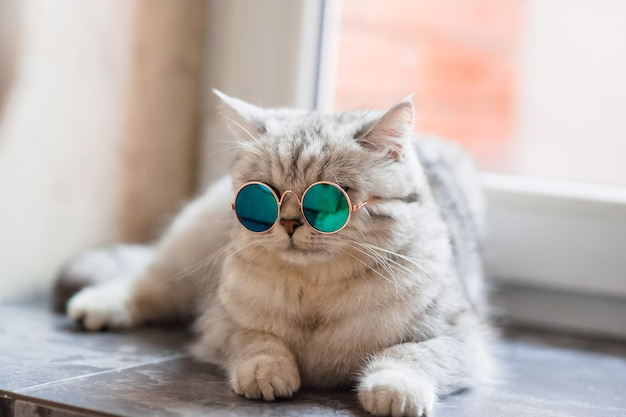

In [6]:
cat_url = "https://img.freepik.com/premium-photo/gray-scottish-cat-is-lying-by-window-cat-is-wearing-green-sunglasses_650650-3159.jpg"
elephants_url = "https://cdn-ccbam.nitrocdn.com/ychWYWPbawiVjyShkPeowOjrCDAYzDmS/assets/static/optimized/rev-725e39e/wp-content/uploads/2019/07/iStock-184652578-1-300x200-1.jpg"
flamingo_url = "https://www.byte.fm/media/broadcasts/vicko-mozara-m82uh_vamhg-unsplash.jpg.600x500_q85_box-0%2C742%2C2983%2C3228_crop_detail.jpg"

cat_image = load_url(cat_url)
elephants_image = load_url(elephants_url)
flamingo_image = load_url(flamingo_url)
cat_image

In [15]:
prompt = "<image>Output: A cat wearing sunglasses.<EOC><image>Output: Elephants walking in the Savanna.<EOC><image>Output: "
response = multimodal_prompt(model, processor, prompt, images=[cat_image, elephants_image, flamingo_image], device=device)
print('prompt:', prompt)
print('output:', response)

torch.Size([1, 3, 1, 3, 224, 224])
prompt: <image>Output: A cat wearing sunglasses.<EOC><image>Output: Elephants walking in the Savanna.<EOC><image>Output: 
output: <image>Output: A cat wearing sunglasses. <EOC> <image>Output: Elephants walking in the Savanna. <EOC> <image>Output: iced <EOC>
